# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib
!pip3 install pydot

In [2]:
!pip list

Package                       Version
----------------------------- ---------
absl-py                       2.0.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.3.0
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites    

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

/var/folders/ys/c57m6lm53_z4013ztl63m9sc0000gn/T/ipykernel_15484/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data')
#data = tf.keras.utils.image_dataset_from_directory('data', image_size=(150,150))

Found 240 files belonging to 10 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()

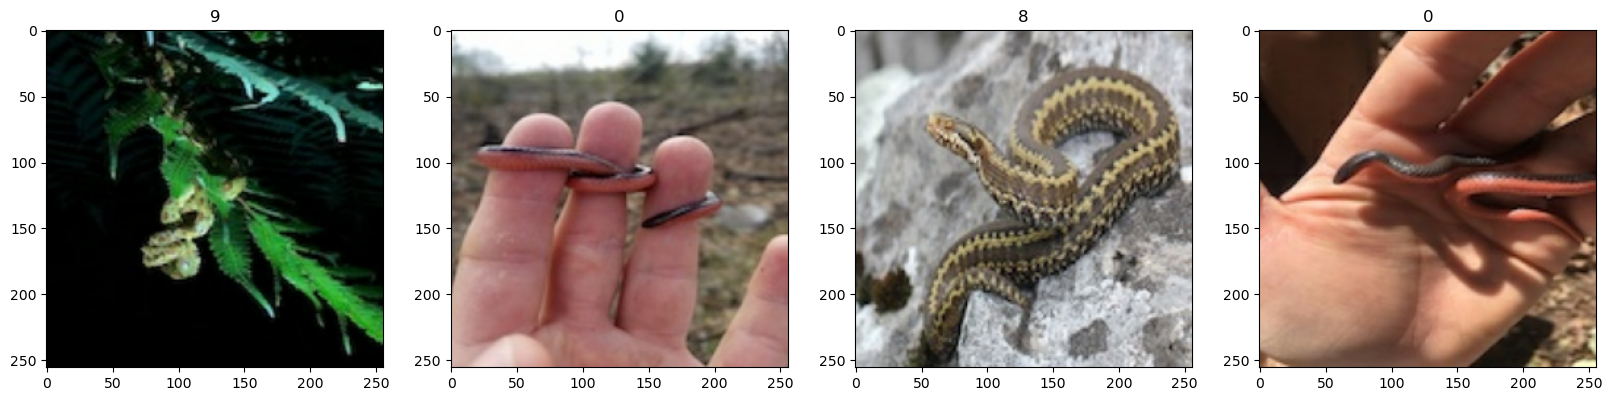

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [15]:
data = data.map(lambda x,y: (x/255, y))
#data = data.map(lambda x,y: (x, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[6.50980413e-01, 4.11764711e-01, 1.56862751e-01],
          [6.55438125e-01, 4.19194251e-01, 1.62806377e-01],
          [6.62331522e-01, 4.30683225e-01, 1.71997547e-01],
          ...,
          [3.99862140e-01, 2.70450354e-01, 1.41038597e-01],
          [3.97564352e-01, 2.68152565e-01, 1.38740808e-01],
          [3.96078438e-01, 2.66666681e-01, 1.37254909e-01]],
 
         [[6.62867665e-01, 4.23651963e-01, 1.65778190e-01],
          [6.67325377e-01, 4.31081504e-01, 1.72847852e-01],
          [6.74218774e-01, 4.42570478e-01, 1.83780327e-01],
          ...,
          [3.74549478e-01, 2.45242193e-01, 1.18802242e-01],
          [3.71381044e-01, 2.43815050e-01, 1.17375091e-01],
          [3.69332105e-01, 2.42892161e-01, 1.16452202e-01]],
 
         [[6.81249976e-01, 4.42034304e-01, 1.79564953e-01],
          [6.85707748e-01, 4.49463844e-01, 1.88375920e-01],
          [6.92601085e-01, 4.60952818e-01, 2.02001110e-01],
          ...,
          [3.35406184e-01, 2.06260473e-01, 8.4416

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

In [18]:
print(len(data))
print(train_size)
print(val_size)
print(test_size)

8
5
2
1


In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout



In [22]:
model = Sequential()

In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
#model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(150,150,3)))

model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

In [24]:
#model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [26]:
#tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# 7. Train

In [27]:
logdir='logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=11, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/11
5/5 [==============================] - 2s 248ms/step - loss: 3.2668 - accuracy: 0.1312 - val_loss: 2.4395 - val_accuracy: 0.1250
Epoch 2/11
5/5 [==============================] - 1s 225ms/step - loss: 2.3572 - accuracy: 0.1312 - val_loss: 2.2835 - val_accuracy: 0.2344
Epoch 3/11
5/5 [==============================] - 1s 226ms/step - loss: 2.2944 - accuracy: 0.1250 - val_loss: 2.2055 - val_accuracy: 0.2969
Epoch 4/11
5/5 [==============================] - 1s 224ms/step - loss: 2.1944 - accuracy: 0.2500 - val_loss: 2.1164 - val_accuracy: 0.3125
Epoch 5/11
5/5 [==============================] - 1s 224ms/step - loss: 2.1103 - accuracy: 0.2250 - val_loss: 1.9797 - val_accuracy: 0.3750
Epoch 6/11
5/5 [==============================] - 1s 224ms/step - loss: 1.9006 - accuracy: 0.3750 - val_loss: 1.9609 - val_accuracy: 0.2969
Epoch 7/11
5/5 [==============================] - 1s 225ms/step - loss: 1.7611 - accuracy: 0.4812 - val_loss: 1.6647 - val_accuracy: 0.4844
Epoch 8/11
5/5 [====

# 8. Plot Performance

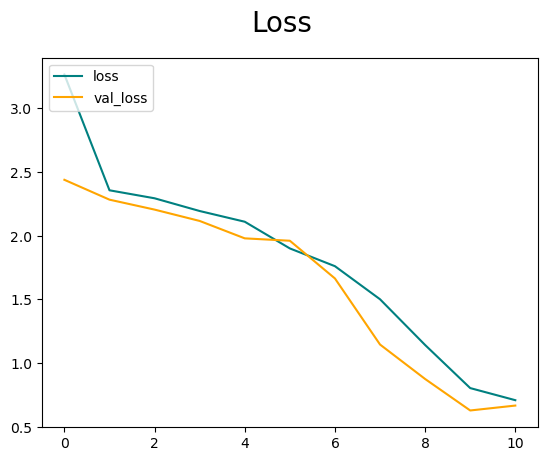

In [30]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

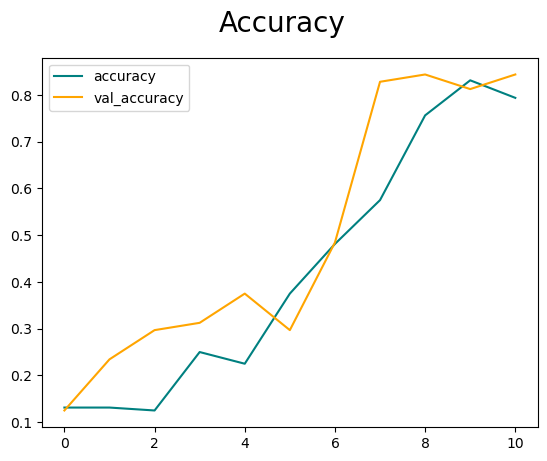

In [31]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [32]:
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt

In [47]:
#used https://stackoverflow.com/questions/56090541/how-to-plot-precision-and-recall-of-multiclass-classifier
precision = dict()
recall = dict()
classes = [41, 83, 111, 373, 384, 497, 590, 616, 698, 751]
for batch in test.as_numpy_iterator(): 
    X, y = batch
    predicted = model.predict(X)
    #predicted = predicted[:,0,...]
    #y = y.reshape(-1,1)
    
    #https://stackoverflow.com/questions/64759271/python-gives-array-is-1-dimensional-but-2-were-indexed-error
    #had to reshape to avoid index error
    predicted = predicted.reshape(-1,10)
    
    #https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.
    #we need to binarize bc precision-recall curve doesn't support multilabel
    Y = label_binarize(y, classes=[0,1,2,3,4,5,6,7,8,9])
    n_classes = Y.shape[1]
    #print(y)
    #print(Y)
    #print(predicted)
    #print(predicted.shape)
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(Y[:, i], predicted[:, i])
        #plt.plot(recall[i], precision[i], lw=2, label=classes[i])
        #print(i)
    #plt.xlabel("recall")
    #plt.ylabel("precision")
    #plt.legend(loc="best")
    #plt.title("precision vs. recall curve")
    #plt.show()
  

1/1 [==============================] - 0s 45ms/step


/Users/dwoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:979: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


# 9 Confusion Matrix

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
#print(len(train))
#print(len(train))
for batch in train.as_numpy_iterator(): 
    X, y = batch
    #print(len(X))
    #print(y)
    yhat = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(y, yhat)
    print(y)
    print(yhat)
    #print(cm)

1/1 [==============================] - 0s 75ms/step
[8 5 8 4 3 2 1 4 2 6 3 2 9 6 1 9 3 2 3 5 4 4 8 4 2 6 0 8 0 5 6 7]
[8 5 8 8 3 2 1 6 2 6 8 2 6 6 1 3 3 2 3 5 4 8 8 8 2 6 0 8 0 8 6 8]
1/1 [==============================] - 0s 64ms/step
[3 7 2 4 1 9 6 6 4 4 2 7 9 3 5 9 7 2 8 1 1 3 5 6 2 9 6 6 7 7 9 8]
[3 7 2 4 1 6 6 6 4 8 2 7 9 8 5 9 7 2 8 1 0 3 5 6 2 9 6 6 7 7 9 8]
1/1 [==============================] - 0s 58ms/step
[8 2 5 9 4 9 5 6 6 5 2 3 8 3 1 8 9 0 5 3 3 1 0 4 9 9 0 0 5 8 5 6]
[8 2 5 9 8 9 5 6 6 5 2 3 8 6 1 8 9 0 5 3 3 1 0 8 9 9 0 0 5 8 5 6]
1/1 [==============================] - 0s 59ms/step
[5 8 4 4 7 2 2 8 3 4 0 0 3 4 9 1 5 8 2 7 1 2 8 8 9 8 3 9 6 3 5 9]
[8 8 7 4 7 2 2 8 3 8 0 0 3 4 8 1 5 8 2 7 1 2 8 8 9 8 8 9 6 8 5 9]
1/1 [==============================] - 0s 58ms/step
[5 0 0 1 8 9 4 4 1 3 1 0 2 0 5 6 4 7 1 6 9 4 2 6 0 1 2 4 1 1 9 7]
[5 0 0 1 8 8 4 4 1 3 6 0 6 0 5 6 4 7 1 6 9 2 2 6 0 1 2 8 5 1 9 7]


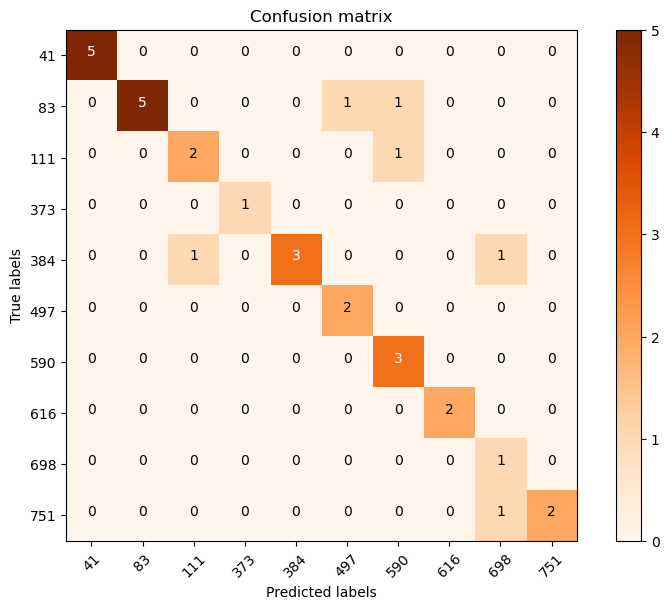

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Oranges')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('41', '83', '111', '373', '384', 
                 '497', '590', '616', '698', '751')
plot_confusion_matrix(cm, target_names)

# 10. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, sparse_categorical_accuracy

In [38]:
pre = Precision()
re = Recall()
#acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = np.argmax(model.predict(X), axis=1)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    #acc.update_state(y, yhat)

1/1 [==============================] - 0s 43ms/step


In [40]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
acc = sparse_categorical_accuracy(y, yhat)


1/1 [==============================] - 0s 37ms/step


In [41]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{np.mean(acc)}, F1 Score:{2/(1/pre.result().numpy()+(1/re.result().numpy()))}')

Precision:1.0, Recall:1.0, Accuracy:0.9375, F1 Score:1.0


# 11. PCA

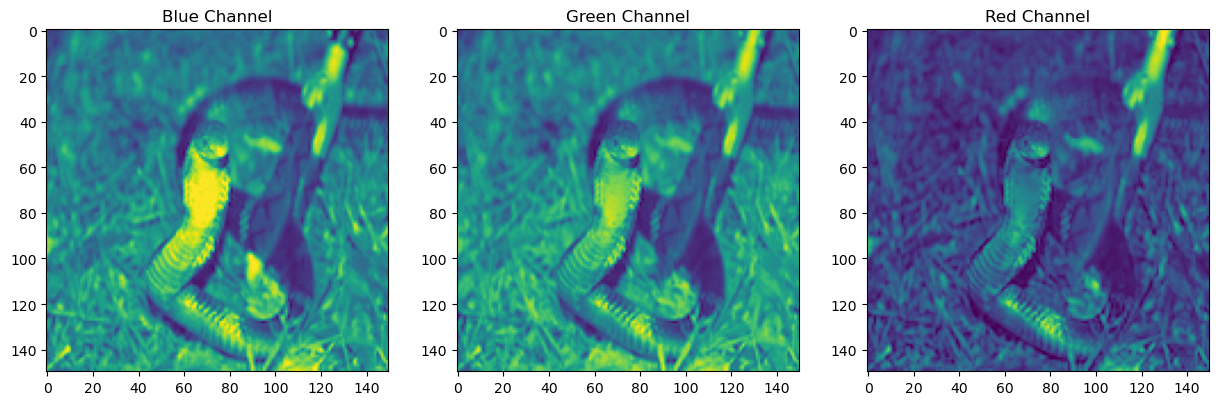

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blue Channel : 0.9592305132860101
Green Channel: 0.9564932332679079
Red Channel  : 0.9390596875578482
(150, 150) (150, 150) (150, 150)
(150, 150, 3)


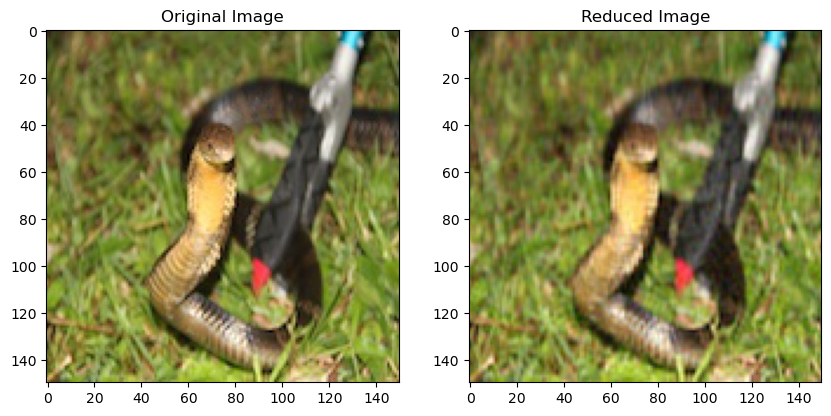

In [42]:
import imageio
import pathlib
from sklearn.decomposition import PCA

#training_paths = pathlib.Path('/content/drive/MyDrive/snake_ml/Snake_Images/497/27b8d0c9b3dd4e608922fc48aba9aeb7.jpg')
#training_sorted = sorted([x for x in training_paths])
#im_path = training_sorted[2]
image = imageio.v2.imread("steve.jpg")


#Splitting into channels
blue,green,red = cv2.split(image)
# Plotting the images
fig = plt.figure(figsize = (15, 7.2))
fig.add_subplot(131)
plt.title("Blue Channel")
plt.imshow(blue)
fig.add_subplot(132)
plt.title("Green Channel")
plt.imshow(green)
fig.add_subplot(133)
plt.title("Red Channel")
plt.imshow(red)
plt.show()


df_blue = blue/255.0
df_green = green/255.0
df_red = red/255.0

pca_b = PCA(n_components=30)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)
pca_g = PCA(n_components=30)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)
pca_r = PCA(n_components=30)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

print(f"Blue Channel : {sum(pca_b.explained_variance_ratio_)}")
print(f"Green Channel: {sum(pca_g.explained_variance_ratio_)}")
print(f"Red Channel  : {sum(pca_r.explained_variance_ratio_)}")

b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)


img_reduced= (cv2.merge((b_arr, g_arr, r_arr)))
print(img_reduced.shape)

fig = plt.figure(figsize = (10, 7.2))
fig.add_subplot(121)
plt.title("Original Image")
plt.imshow(image)
fig.add_subplot(122)
plt.title("Reduced Image")
plt.imshow(img_reduced)
plt.show()